In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* CAD/JPY exchange rate returns. 

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Data Preparation

### Returns

In [4]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
cad_jpy_df['Return'] = cad_jpy_df.Price.pct_change() * 100
cad_jpy_df = cad_jpy_df.resample('D').first() #aggregation function 
cad_jpy_df = cad_jpy_df.dropna()
cad_jpy_df.head()

,Price,Open,High,Low,Return
Date,,,,,
1990-01-03,125.30,125.24,125.30,125.24,-0.846720
1990-01-04,123.46,123.41,123.46,123.41,-1.468476
1990-01-05,124.54,124.48,124.54,124.48,0.874777
1990-01-08,124.27,124.21,124.27,124.21,-0.216798
1990-01-09,125.10,125.04,125.10,125.04,0.667901


### Lagged Returns 

In [5]:
# Create a lagged return using the shift function
cad_jpy_df['Lag_Return'] = cad_jpy_df.Return.shift()
cad_jpy_df['Return_Difference'] = cad_jpy_df.Return.diff()
cad_jpy_df.head()

,Price,Open,High,Low,Return,Lag_Return,Return_Difference
Date,,,,,,,
1990-01-03,125.30,125.24,125.30,125.24,-0.846720,NaN,NaN
1990-01-04,123.46,123.41,123.46,123.41,-1.468476,-0.846720,-0.621756
1990-01-05,124.54,124.48,124.54,124.48,0.874777,-1.468476,2.343253
1990-01-08,124.27,124.21,124.27,124.21,-0.216798,0.874777,-1.091575
1990-01-09,125.10,125.04,125.10,125.04,0.667901,-0.216798,0.884698


### Train Test Split

In [6]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = cad_jpy_df[:'2018'].dropna()
test = cad_jpy_df['2019':].dropna() 

In [7]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lag_Return"].to_frame()
X_test = test["Lag_Return"].to_frame()
y_train = train["Return"]
y_test = test["Return"]

In [8]:
# Preview the X_train data
X_train.head().dropna()

,Lag_Return
Date,
1990-01-04,-0.846720
1990-01-05,-1.468476
1990-01-08,0.874777
1990-01-09,-0.216798
1990-01-10,0.667901


In [9]:
y_train.head().dropna()

Date
1990-01-04   -1.468476
1990-01-05    0.874777
1990-01-08   -0.216798
1990-01-09    0.667901
1990-01-10    0.567546
Name: Return, dtype: float64

In [10]:
y_train.count


<bound method Series.count of Date
1990-01-04   -1.468476
1990-01-05    0.874777
1990-01-08   -0.216798
1990-01-09    0.667901
1990-01-10    0.567546
                ...   
2018-12-25   -0.024640
2018-12-26    1.121380
2018-12-27   -0.658055
2018-12-28   -0.809617
2018-12-31   -0.643087
Name: Return, Length: 7554, dtype: float64>

# Linear Regression Model

In [11]:
X_train.count


<bound method DataFrame.count of             Lag_Return
Date                  
1990-01-04   -0.846720
1990-01-05   -1.468476
1990-01-08    0.874777
1990-01-09   -0.216798
1990-01-10    0.667901
...                ...
2018-12-25   -0.745904
2018-12-26   -0.024640
2018-12-27    1.121380
2018-12-28   -0.658055
2018-12-31   -0.809617

[7554 rows x 1 columns]>

In [12]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression



In [13]:
# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

**Note:** We want to evaluate the model using data that it has never seen before, in this case: `X_test`.

In [14]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)#, array.reshape(1, -1)
predictions

array([ 1.35989860e-02, -5.56101232e-03,  5.30411380e-03,  9.37506080e-03,
       -4.43653014e-02, -2.09103358e-02, -7.64486582e-03, -1.53978532e-03,
       -3.36841270e-03,  2.88507168e-04,  1.00531411e-02, -1.77832651e-02,
       -1.43378327e-02, -1.54411671e-03, -1.82298056e-02,  6.28889834e-03,
        1.56982585e-02, -1.00727470e-02, -1.84628096e-03, -2.52463775e-02,
        1.01943498e-02, -1.54588185e-03, -1.69880141e-02, -4.26017518e-03,
       -2.05033074e-02, -9.62185311e-03, -1.26269860e-03,  1.42312923e-02,
        1.82429897e-02, -5.78102661e-03, -1.24219309e-02, -1.74968909e-02,
       -1.08275272e-02,  1.66217264e-02, -1.14645031e-02, -6.64374112e-03,
       -8.42934432e-03, -1.40781606e-02,  1.14898226e-02, -2.00561178e-02,
       -6.76412924e-04,  4.36474534e-03, -1.37504291e-02, -9.26048279e-03,
        9.64649120e-03,  2.88432627e-03,  2.30135583e-03,  1.80923858e-02,
        3.55094858e-03, -4.61874823e-05, -7.57532760e-03, -1.32770355e-02,
       -6.94408988e-03, -

In [15]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

In [16]:
Results.head(2)

,Return,Predicted Return
Date,,
2019-01-01,0.124471,0.013599
2019-01-02,-0.310791,-0.005561


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

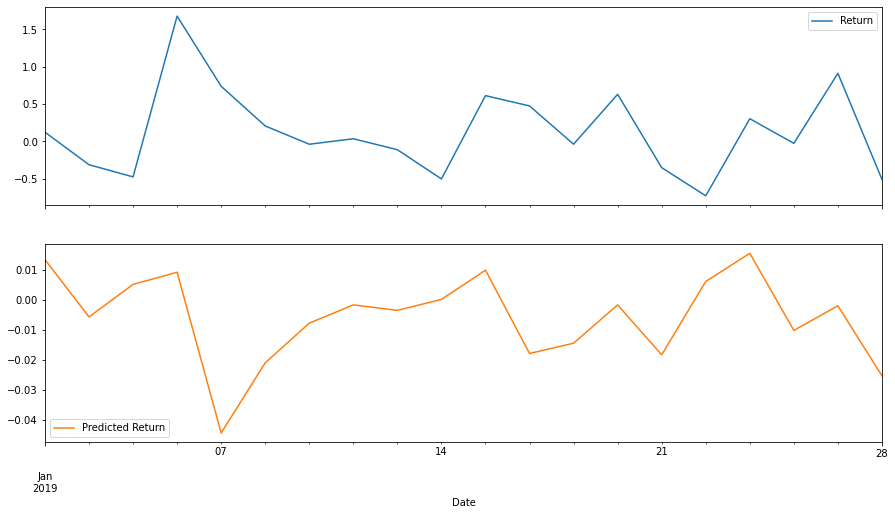

In [17]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(figsize = (15,8), subplots=True)

<AxesSubplot:xlabel='Date'>

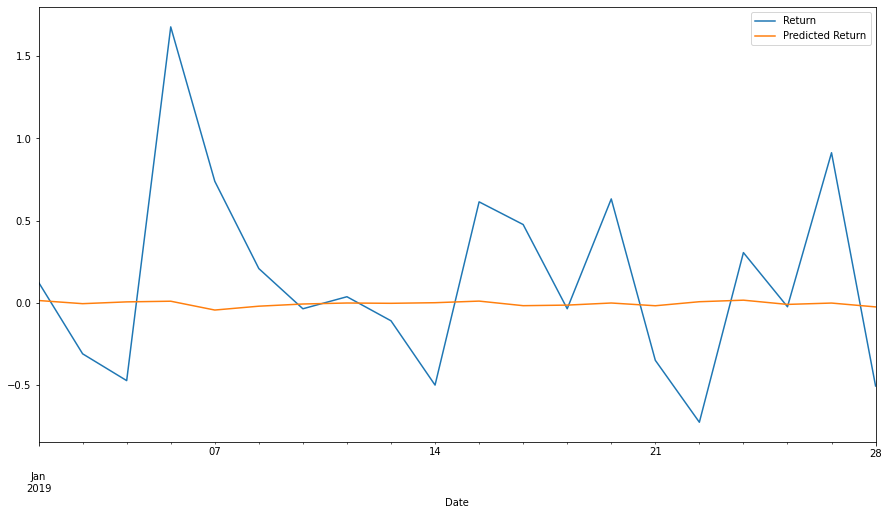

In [18]:
Results[:20].plot(figsize = (15,8))

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (`X_test` and `y_test`)

In [19]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe from above)
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)


# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.6878550383598834


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [20]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)


# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")
#may need to limit the data somehow 

In-sample Root Mean Squared Error (RMSE): 0.8342483222052092


# Conclusions

**Question:** Does this model perform better or worse on out-of-sample data as compared to in-sample data?

**Answer:** YOUR ANSWER HERE

In [21]:
print("the out of sample data is better as it produces a lower mean squared error, meaning better accuracy in general") 

the out of sample data is better as it produces a lower mean squared error, meaning better accuracy in general
